In [1]:
# Simeng Yang, 20655500
# CS 480 S'20 Ludum Dare Kaggle Competition submission

import lightgbm as lgbm

import pandas as pd
import numpy as np

In [2]:
# Fetch the training and test data from CSVs
# When using Google Colab, you should wait for the CSV files
# to be fully uploaded before trying to read the data
# Otherwise, the CSV files won't be in a complete state
# If data has been skipped, please restart the run

def _get_data(test_path, train_path):
    test_data = pd.read_csv(test_path, engine='python', error_bad_lines=False)
    train_data = pd.read_csv(train_path, engine='python', error_bad_lines=False)

    train_labels = train_data['label']
    train_data.drop(['label'], axis=1, inplace=True)

    return train_data, train_labels, test_data

# Paths to train and test CSV files
# These relative paths assume the CSV files are in the same directory as the Notebook
test_path = "test.csv"
train_path = "train.csv"

train_data, train_labels, test_data = _get_data(test_path, train_path)

# Store indices
train_indices = train_data['id']
test_indices = test_data['id']

In [3]:
# List of relevant features to train and predict on
# audio-average and audio-rank etc. were not included,
# due to ranking poorly in feature importance for the LGBM model 

relevant_cols = [
  "category",
  # "num-comments",
  # "feedback-karma",
  "ratings-received",

  # "num-authors",
  # "prev-games",  

  "fun-average",
  "innovation-average",
  "theme-average",
  "graphics-average",
  # "audio-average",
  "humor-average",
  "mood-average",
  
  "fun-rank",
  "innovation-rank",
  "theme-rank",
  "graphics-rank",
  # "audio-rank",
  "humor-rank",
  "mood-rank",

  "competition-num",

  # # For NLP
  # "description"
]

train_data = train_data[relevant_cols]
test_data = test_data[relevant_cols]

In [4]:
# # # # # # #
# NLP START #
# # # # # # #

'''
The idea behind the use of NLP here is to apply sentiment analysis to the
descriptions of each game.

The TextBlob library is used for extracting the sentiment polarity from
each description, a score that varies from -1 to 1 for the most negative to
the most positive sentiments. 

It was theorized that more positive game descriptions may have been weakly predictive
of higher ratings for each game.

However, this hypothesis was not substantially supported by the data, with
the model performing slightly worse to indifferently with the "sentiment_polarity" feature than without.
For instance, the accuracy on the validation set with "sentiment_polarity" may
have been 0.9444, but was 0.9446 without "sentiment_polarity". 
Furthermore, the graph of feature importance from LGBM showed that "sentiment_polarity"
did not explain much of the variance of the data. 
Therefore, it was decided to not include "sentiment_polarity" in the final model.
'''
# # To include "sentiment_polarity", uncomment these lines
# 
# # import the necessary packages
# import textblob
# from bs4 import BeautifulSoup
# import warnings
# 
# warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
# 
# # Remove HTML from each description
# def clean_html(text):
#   soup = BeautifulSoup(text, 'lxml')
#   without_html = soup.get_text()
#   return without_html

# # Apply sentiment analysis towards descriptions in the training data
# descriptions = train_data["description"]
# # Rudimentary data cleaning
# descriptions = descriptions.apply(lambda x: str(x) if isinstance(x, float) else x)
# descriptions = descriptions.apply(lambda x: clean_html(x))

# # Compute sentiment polarity of each description
# sentiment_polarity = [textblob.TextBlob(description).sentiment.polarity for description in descriptions]

# # Apply sentiment analysis towards descriptions in the test data
# descriptions = test_data["description"]
# # Rudimentary data cleaning
# descriptions = descriptions.apply(lambda x: str(x) if isinstance(x, float) else x)
# descriptions = descriptions.apply(lambda x: clean_html(x))

# # Compute sentiment polarity of each description
# sentiment_polarity = [textblob.TextBlob(description).sentiment.polarity for description in descriptions]

# train_data.drop('description', axis=1, inplace=True)
# test_data.drop('description', axis=1, inplace=True)
# relevant_cols.remove('description')

# train_data['sentiment_polarity'] = sentiment_polarity
# test_data['sentiment_polarity'] = sentiment_polarity

# relevant_cols += ['sentiment_polarity']

# # # # # #
# NLP END #
# # # # # #

'\nThe idea behind the use of NLP here is to apply sentiment analysis to the\ndescriptions of each game.\n\nThe TextBlob library is used for extracting the sentiment polarity from\neach description, a score that varies from -1 to 1 for the most negative to\nthe most positive sentiments. \n\nIt was theorized that more positive game descriptions may have been weakly predictive\nof higher ratings for each game.\n\nHowever, this hypothesis was not substantially supported by the data, with\nthe model performing slightly worse to indifferently with the "sentiment_polarity" feature than without.\nFor instance, the accuracy on the validation set with "sentiment_polarity" may\nhave been 0.9444, but was 0.9446 without "sentiment_polarity". \nFurthermore, the graph of feature importance from LGBM showed that "sentiment_polarity"\ndid not explain much of the variance of the data. \nTherefore, it was decided to not include "sentiment_polarity" in the final model.\n'

In [5]:
# # # # # # #
# CV START  #
# # # # # # #

'''
The idea behind the use of CV here is to compute the colorfulness of each thumbnail image per game.

The OpenCV (cv2) library is used for computing the colorfulness rating from
each thumbnail image, with a higher score indicating more colorful images, based on the RGB components of each image.

It was theorized that more colorful game thumbnail images may have been weakly correlated
with higher ratings for each game as a rough proxy for image aesthetic qualities.

However, this hypothesis was not well substantiated by the data, with
the model performing indifferently with the "colorfulness" feature than without in simulated train-validation splits.
For instance, the accuracy on the validation set with "colorfulness" may
have been 0.9466, but was also 0.9446 without "colorfulness". 
Furthermore, the graph of feature importance from LGBM showed that "colorfulness"
ranked among the least explanatory features for the data. 
Therefore, it was decided to not include "colorfulness" in the final model.
'''
# # To include "colourfulness", uncomment these lines
# # Please be aware that uploading all the images to a remote compute Notebook environment such as Google Colab
# # may take a long time, so it may be better to try running the Notebook locally with all the files instead
# 
# # import the necessary packages
# import imutils
# import cv2
# import os
# 
# # Adapted from https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/
# # Compute the colorfulness ratings for the thumbnails associated with the training and test indices,
# # based on the approach detailed by Hasler and Süsstrunk’s in their 2003 paper, Measuring colorfulness in nature images.
# def image_colorfulness(image):
#     # split the image into its respective RGB components
#     (B, G, R) = cv2.split(image.astype("float"))
#     # compute rg = R - G
#     rg = np.absolute(R - G)
#     # compute yb = 0.5 * (R + G) - B
#     yb = np.absolute(0.5 * (R + G) - B)
#     # compute the mean and standard deviation of both `rg` and `yb`
#     (rbMean, rbStd) = (np.mean(rg), np.std(rg))
#     (ybMean, ybStd) = (np.mean(yb), np.std(yb))
#     # combine the mean and standard deviations
#     stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
#     meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
#     # derive the "colorfulness" metric and return it
#     return stdRoot + (0.3 * meanRoot)

# # Relative location of the thumbnails
# thumbnails = "thumbnails/thumbnails/"

# colorfulness = []

# # Iterate over each test index, try to find its associated thumbnail image
# # and compute the colorfulness rating of that image
# for test_index in test_indices:
#     path = thumbnails + str(test_index) + ".jpg"
#     if os.path.exists(path):
#         try:
#             image = cv2.imread(path)
#         except:
#             colorfulness.append(-1)
#             continue

#         if image is None:
#             colorfulness.append(-1)
#             continue

#         # resize image to speed up computation
#         image = imutils.resize(image, width=250)
#         C = image_colorfulness(image)
#         colorfulness.append(C)
#     else:
#         colorfulness.append(-1)

# print("Done with test images")
# test_data['colorfulness'] = colorfulness

# colorfulness = []

# # Iterate over each training index, try to find its associated thumbnail image
# # and compute the colorfulness rating of that image
# for train_index in train_indices:
#     path = thumbnails + str(train_index) + ".jpg"
#     if os.path.exists(path):
#         try:
#             image = cv2.imread(path)
#         except:
#             colorfulness.append(-1)
#             continue

#         if image is None:
#             colorfulness.append(-1)
#             continue

#         # resize image to speed up computation
#         image = imutils.resize(image, width=250)
#         C = image_colorfulness(image)
#         colorfulness.append(C)
#     else:
#         colorfulness.append(-1)

# print("Done with train images")
# train_data['colorfulness'] = colorfulness

# relevant_cols += ['colorfulness']

# # # # # #
# CV END  #
# # # # # #

'\nThe idea behind the use of CV here is to compute the colorfulness of each thumbnail image per game.\n\nThe OpenCV (cv2) library is used for computing the colorfulness rating from\neach thumbnail image, with a higher score indicating more colorful images, based on the RGB components of each image.\n\nIt was theorized that more colorful game thumbnail images may have been weakly correlated\nwith higher ratings for each game as a rough proxy for image aesthetic qualities.\n\nHowever, this hypothesis was not well substantiated by the data, with\nthe model performing indifferently with the "colorfulness" feature than without in simulated train-validation splits.\nFor instance, the accuracy on the validation set with "colorfulness" may\nhave been 0.9466, but was also 0.9446 without "colorfulness". \nFurthermore, the graph of feature importance from LGBM showed that "colorfulness"\nranked among the least explanatory features for the data. \nTherefore, it was decided to not include "colorfu

In [6]:
# Feature engineering:
# Construct additional features for training and prediction, for scores and ranks
# For the scores, example engineered features include the average, max and min of each
# row of ratings etc. 

# For training data
average_scores = train_data[[
  "fun-average",
  "innovation-average",
  "theme-average",
  "graphics-average",
  # "audio-average",
  "humor-average",
  "mood-average",
]]

train_data['score_average'] = average_scores.replace(-1, np.NaN).mean(axis=1).apply(lambda x: np.log(x)).replace(np.NaN, -1)
train_data['score_min'] = average_scores.replace(-1, np.NaN).min(axis=1).apply(lambda x: np.log(x)).replace(np.NaN, -1)
train_data['score_max'] = average_scores.replace(-1, np.NaN).max(axis=1).apply(lambda x: np.log(x)).replace(np.NaN, -1)
train_data['score_std'] = average_scores.replace(-1, np.NaN).std(axis=1).replace(np.NaN, -1)
train_data['score_percentile'] = train_data[['score_average', 'competition-num', "category"]].replace(-1, np.NaN).groupby(["category", 'competition-num']).rank(pct=True, ascending=True).replace(np.NaN, -1)

train_data[[
  "fun-average",
  "innovation-average",
  "theme-average",
  "graphics-average",
  # "audio-average",
  "humor-average",
  "mood-average",
]] = average_scores.replace(-1, np.NaN).apply(lambda x: np.log(x)).replace(np.NaN, -1)

average_ranks = train_data[[
  "competition-num",
  "category",

  "fun-rank",
  "innovation-rank",
  "theme-rank",
  "graphics-rank",
  # "audio-rank",
  "humor-rank",
  "mood-rank"
]]

# Scale the ranks with min-max scaling to being between 0 and 1
average_ranks = average_ranks.replace(-1, np.NaN)
average_ranks = average_ranks.groupby(["competition-num", "category"]).apply(lambda x: (x-x.min())/(x.max()-x.min()))
average_ranks = average_ranks.replace(np.NaN, -1)

train_data[[
  "fun-rank",
  "innovation-rank",
  "theme-rank",
  "graphics-rank",
  # "audio-rank",
  "humor-rank",
  "mood-rank"
]] = average_ranks

# ----------

# For the test data
average_scores = test_data[[
  "fun-average",
  "innovation-average",
  "theme-average",
  "graphics-average",
  # "audio-average",
  "humor-average",
  "mood-average",
]]

test_data['score_average'] = average_scores.replace(-1, np.NaN).mean(axis=1).apply(lambda x: np.log(x)).replace(np.NaN, -1)
test_data['score_min'] = average_scores.replace(-1, np.NaN).min(axis=1).apply(lambda x: np.log(x)).replace(np.NaN, -1)
test_data['score_max'] = average_scores.replace(-1, np.NaN).max(axis=1).apply(lambda x: np.log(x)).replace(np.NaN, -1)
test_data['score_std'] = average_scores.replace(-1, np.NaN).std(axis=1).replace(np.NaN, -1)
test_data['score_percentile'] = test_data[['score_average', 'competition-num', "category"]].replace(-1, np.NaN).groupby(["category", 'competition-num']).rank(pct=True, ascending=True).replace(np.NaN, -1)

test_data[[
  "fun-average",
  "innovation-average",
  "theme-average",
  "graphics-average",
  # "audio-average",
  "humor-average",
  "mood-average",
]] = average_scores.replace(-1, np.NaN).apply(lambda x: np.log(x)).replace(np.NaN, -1)

average_ranks = test_data[[
  "competition-num",
  "category",

  "fun-rank",
  "innovation-rank",
  "theme-rank",
  "graphics-rank",
  # "audio-rank",
  "humor-rank",
  "mood-rank"
]]

# Scale the ranks with min-max scaling to being between 0 and 1
average_ranks = average_ranks.replace(-1, np.NaN)
average_ranks = average_ranks.groupby(["competition-num", "category"]).apply(lambda x: (x-x.min())/(x.max()-x.min()))
average_ranks = average_ranks.replace(np.NaN, -1)

test_data[[
  "fun-rank",
  "innovation-rank",
  "theme-rank",
  "graphics-rank",
  # "audio-rank",
  "humor-rank",
  "mood-rank"
]] = average_ranks

# ----------

relevant_cols += ['score_average', 'score_std', 'score_max', 'score_min', 'score_percentile']

# Drop a couple features that aren't relevant beyond feature engineering
train_data.drop('competition-num', axis=1, inplace=True)
test_data.drop('competition-num', axis=1, inplace=True)

relevant_cols.remove('competition-num')

train_data.drop('category', axis=1, inplace=True)
test_data.drop('category', axis=1, inplace=True)

relevant_cols.remove('category')

In [7]:
# Redefine our train and test datasets for use in validation vs actual predictions
# Validation in this context refers to simulating a train-test split on the training data,
# rather than actually predicting on the test dataset, the labels of which are unknown

# # For validation
# from sklearn.model_selection import train_test_split
# X_train, X_valid, Y_train, Y_valid = train_test_split(train_data, train_labels, random_state=0, test_size=0.22)

# For actual testing
X_train, Y_train = train_data, train_labels

In [8]:
# Construct LGBM wrappers for our datasets

# For testing and validation
lgbm_train = lgbm.Dataset(X_train, Y_train, feature_name=relevant_cols)

# # For validation only
# lgbm_val = lgbm.Dataset(X_valid, Y_valid, feature_name=relevant_cols)

In [9]:
# Hyperparameters for LGBM

lgbm_params =  {
    'task': 'train',

    'boosting_type': 'gbdt',

    'objective': 'multiclass',
    'num_class': 6, # 6 classes, for 0, ..., 5

    'metric': ['multi_error', 'multi_logloss'],

    "learning_rate": 0.00447,
}

In [10]:
# Perform cross-validation with the LGBM hyperparameters
# to determine the optimal boosting round

lgbm_cv = lgbm.cv(
    params = lgbm_params,
    train_set = lgbm_train,
    num_boost_round=2000,
    stratified=True,
    nfold = 5,
    verbose_eval=50,
    seed = 0,
    early_stopping_rounds=150,
    feature_name=relevant_cols,
    shuffle=True
    )

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[50]	cv_agg's multi_logloss: 0.895848 + 0.00436081	cv_agg's multi_error: 0.0912612 + 0.00176584
[100]	cv_agg's multi_logloss: 0.71955 + 0.00539812	cv_agg's multi_error: 0.0713959 + 0.00389809
[150]	cv_agg's multi_logloss: 0.591386 + 0.00612156	cv_agg's multi_error: 0.0645161 + 0.00383178
[200]	cv_agg's multi_logloss: 0.494947 + 0.00679251	cv_agg's multi_error: 0.062648 + 0.00485945
[250]	cv_agg's multi_logloss: 0.421395 + 0.00733776	cv_agg's multi_error: 0.0618735 + 0.00607945
[300]	cv_agg's multi_logloss: 0.36467 + 0.00793293	cv_agg's multi_error: 0.0612357 + 0.00625599
[350]	cv_agg's multi_logloss: 0.320332 + 0.00846568	cv_agg's multi_error: 0.0606433 + 0.00631677
[400]	cv_agg's multi_logloss: 0.285422 + 0.00896468	cv_agg's multi_error: 0.0599598 + 0.00610437
[450]	cv_agg's multi_logloss: 0.257903 + 0.00933798	cv_agg's multi_error: 0.0599144 + 0.00556548
[500]	cv_agg's multi_logloss: 0.236025 + 0.00970168	cv_agg's multi_error: 0.0592309 + 0.00521693
[550]	cv_agg's multi_logloss: 0.21

In [11]:
# Determine and report errors from cross validation
# as well as the optimal number of rounds

multi_error = lgbm_params["metric"][0]
best_multi_error = min(lgbm_cv[str(multi_error) + '-mean'])

multi_logloss = lgbm_params["metric"][1]
best_multi_logloss = min(lgbm_cv[str(multi_logloss) + '-mean'])

optimal_rounds = np.argmin(lgbm_cv[str(multi_error) + '-mean'])

print("\nOptimal Round: {}\nOptimal Scores:\nmulti_error -- {} + {},\nmulti_logloss -- {} + {}".format(
    optimal_rounds,
    best_multi_error,
    lgbm_cv[str(multi_error) + '-stdv'][optimal_rounds],
    best_multi_logloss,
    lgbm_cv[str(multi_logloss) + '-stdv'][optimal_rounds]
))


Optimal Round: 738
Optimal Scores:
multi_error -- 0.05786398072215121 + 0.005133976605571282,
multi_logloss -- 0.179062138421643 + 0.010756638330667076


In [12]:
# Train the final LGBM model with the chosen hyperparameters
# and optimal number of rounds

lgbm_final = lgbm.train(
        lgbm_params,
        lgbm_train,
        num_boost_round=optimal_rounds + 1,
        valid_sets=lgbm_train,
        feature_name=relevant_cols,
        verbose_eval=100,
)

[100]	training's multi_logloss: 0.70524	training's multi_error: 0.0633315
[200]	training's multi_logloss: 0.473775	training's multi_error: 0.0518954
[300]	training's multi_logloss: 0.337933	training's multi_error: 0.0474759
[400]	training's multi_logloss: 0.253884	training's multi_error: 0.0442865
[500]	training's multi_logloss: 0.199988	training's multi_error: 0.0417806
[600]	training's multi_logloss: 0.164388	training's multi_error: 0.0404137
[700]	training's multi_logloss: 0.140249	training's multi_error: 0.0389557


In [13]:
# Predict ratings using the trained LGBM model
# For testset
predictions = pd.DataFrame(lgbm_final.predict(test_data)).idxmax(axis=1)

# # For predicting on validation set
# predictions = pd.DataFrame(lgbm_final.predict(X_valid)).idxmax(axis=1)

In [14]:
# # For validation, report the performance
# # Comment this out for the actual test dataset

# predictions.reset_index(drop=True, inplace=True)
# Y_valid.reset_index(drop=True, inplace=True)

# from sklearn.metrics import accuracy_score
# print('accuracy_score: {}'.format(accuracy_score(predictions, Y_valid)))

# from sklearn.metrics import precision_recall_fscore_support as score
# precision, recall, fscore, support = score(Y_valid, predictions, average=None, zero_division=1,
# labels=[0, 1, 2, 3, 4, 5])

# stats_df = pd.DataFrame(data=[precision, recall, fscore, support],
#                   index=['precision', 'recall', 'fscore', 'support'])

# print(stats_df)

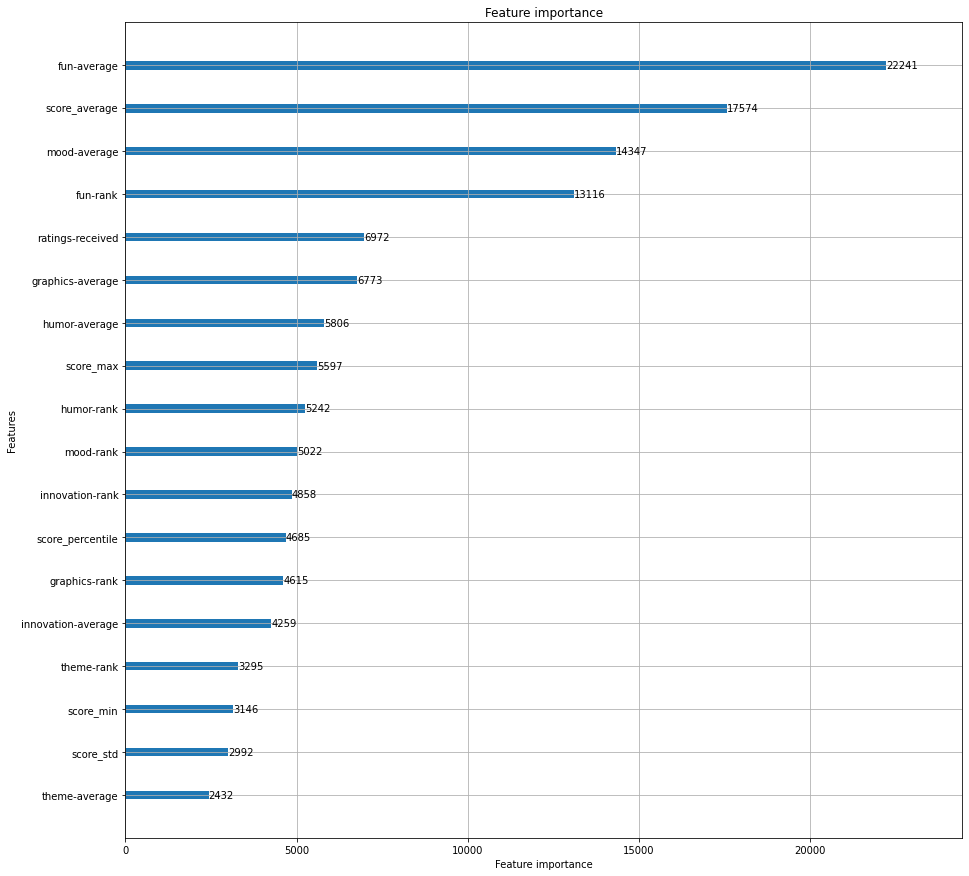

In [15]:
# Report relative feature importances

ax = lgbm.plot_importance(lgbm_final, figsize=(15,15))

In [16]:
predictions.tail()

4954    4
4955    4
4956    4
4957    4
4958    4
dtype: int64

In [17]:
res = pd.concat([test_indices, predictions], axis=1, keys=['id', 'label'])
res.tail()

,id,label
4954,199422,4
4955,199706,4
4956,200853,4
4957,201502,4
4958,202646,4


In [18]:
# Write predictions to CSV

res.to_csv('predictions.csv', index=False)  